## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II
# Micro-Proyecto 2

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

A continuación escriba los nombres de los integrantes del grupo.


##### Grupo 3:
##### Jonny Eduardo Coronel
##### Ivan Galindo Gaviria
##### Sergio Ardila Rodríguez

### Introducción
Una aplicación de música quiere actualizar su aplicación online para que genere recomendaciones a sus usuarios de nuevos artistas para escuchar. El sistema de recomendación debe tomar en cuenta las preferencias de cada usuario, con el fin de ofrecer recomendaciones automáticas y personalizadas.

La base de datos que va a trabajar se ha tomado de http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html


### Enunciado 1
Por ello se le pide a usted, en calidad de consultor externo, desarrollar un algoritmo de recomendación de artistas para cada usuario. Implemente el algoritmo a partir del conjunto de datos: "lastfm-dataset-360K/usersha1-profile.tsv" y evalúe su desempeño con respecto a la métrica apropiada.

### Enunciado 2
Una vez a desarrollado su primer sistema de recomendación, intente mejorarlo con respecto a la métrica de su elección, considerando además la información que encuentra en "lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv", donde encuentra información de tipo socio-demográfico por usuario.

Veamos los datos con los que vamos a trabajar:

In [3]:
import pandas as pd
import tarfile
import numpy as np
import scipy.sparse as sparse 
from scipy.sparse.linalg import spsolve
import scipy
import implicit
from sklearn import metrics
import random
import datetime

In [4]:
import matplotlib.pyplot as plt   
import plotly
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.metrics.pairwise import linear_kernel

In [5]:
import surprise
from surprise import Reader
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import LeaveOneOut

Importamos y descomprimimos los datos:

In [6]:
tf = tarfile.open("lastfm-dataset-360K.tar.gz")
tf.extractall()

Veamos los archivos que hemos importado:

In [7]:
tf.getmembers()

[<TarInfo 'lastfm-dataset-360K' at 0x28a3ca0cf20>,
 <TarInfo 'lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv' at 0x28a3ca12110>,
 <TarInfo 'lastfm-dataset-360K/README.txt' at 0x28a3ca12048>,
 <TarInfo 'lastfm-dataset-360K/mbox_sha1sum.py' at 0x28a3ca121d8>,
 <TarInfo 'lastfm-dataset-360K/usersha1-profile.tsv' at 0x28a3ca122a0>]

Veamos el archivo con la informacion de los usuarios y sus artistas preferidos. Esta base de datos nos dice cuantas veces un usuario a escuchado a un artista.

In [348]:
# leemos el archivo con columnas user/artist/plays
data = pd.read_table("lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv", 
                         usecols=[0, 2, 3], 
                         names=['user', 'artist', 'plays'])




In [349]:
data.head(10)

,user,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


También podemos ver informacion social/demográfica sobre los usuarios:

In [379]:
# leemos el archivo con columnas user/gender/age/country
dataP = pd.read_table("lastfm-dataset-360K/usersha1-profile.tsv", 
                         usecols=[0, 1, 2, 3], 
                         names=['user', 'gender', 'age', 'country'])


In [380]:
dataP.head(10)

,user,gender,age,country
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States
5,0000c176103e538d5c9828e695fed4f7ae42dd01,m,20.0,United Kingdom
6,0000ee7dd906373efa37f4e1185bfe1e3f8695ae,m,17.0,Finland
7,0000ef373bbd0d89ce796abae961f2705e8c1faf,f,22.0,Poland
8,0000f687d4fe9c1ed49620fbc5ed5b0d7798ea20,f,24.0,Spain
9,0001399387da41d557219578fb08b12afa25ab67,m,NaN,Ukraine


## Descriptivas de la base

In [350]:
#Conteo de valores perdidos 
print('total =', data.isnull().sum().sum())

total = 204


In [351]:
data.isnull().sum(axis = 0)

user        0
artist    204
plays       0
dtype: int64

In [352]:
#identificando duplicados
data[data.duplicated(subset=['user','artist'], keep=False)]

,user,artist,plays
69147,00f9e7b0462685f293dc09c28a5efdc971095409,delirious,141
69175,00f9e7b0462685f293dc09c28a5efdc971095409,delirious,86
260917,03d773fc144d1aa005e6d40c40912cd5921e3524,タテタカコ,179
260934,03d773fc144d1aa005e6d40c40912cd5921e3524,タテタカコ,123
312791,049f1a9fcffff1a3ff38042348b7b3fbb5c0f46e,big bang,888
312796,049f1a9fcffff1a3ff38042348b7b3fbb5c0f46e,big bang,363
563426,083ad4034c1b79cb7e30d555a82ef21fc2decb7f,big bang,534
563431,083ad4034c1b79cb7e30d555a82ef21fc2decb7f,big bang,263
961510,0e0e321fa773a3e73ef719fb72c05b73f2f54a9f,ゴダイゴ,236
961525,0e0e321fa773a3e73ef719fb72c05b73f2f54a9f,ゴダイゴ,124


In [353]:
#quitar duplicados 
data = data.drop_duplicates(['user','artist'],keep= 'last')

In [354]:
#eliminar nans
data = data.dropna(subset=['user','artist'])

In [355]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17535376 entries, 0 to 17535654
Data columns (total 3 columns):
user      object
artist    object
plays     int64
dtypes: int64(1), object(2)
memory usage: 535.1+ MB


In [357]:
data.describe()

,plays
count,1.753538e+07
mean,2.151934e+02
std,6.144841e+02
min,0.000000e+00
25%,3.500000e+01
50%,9.400000e+01
75%,2.240000e+02
max,4.191570e+05


In [358]:
artist_gr = data.groupby('artist').agg({'plays': ['count','sum', 'mean', 'min', 'max']})
artist_gr.columns = ['plays_count', 'plays_sum', 'plays_mean', 'plays_min', 'plays_max']
artist_gr = artist_gr.sort_values('plays_count', ascending=False)
artist_gr.head(10)

,plays_count,plays_sum,plays_mean,plays_min,plays_max
artist,,,,,
radiohead,77254,27426234,355.013773,1,106639
the beatles,76245,30466827,399.591147,1,51238
coldplay,66658,16686772,250.334123,1,118857
red hot chili peppers,48924,13547741,276.914009,1,40160
muse,46954,15451683,329.081292,1,62854
metallica,45233,15481852,342.268963,1,44155
pink floyd,44443,15943557,358.741692,1,31957
the killers,41229,9595757,232.742899,1,27464
linkin park,39773,12836638,322.747542,1,99005


In [359]:
artist_gr = artist_gr.sort_values('plays_sum', ascending=False)
artist_gr[['plays_sum']].head(10)

,plays_sum
artist,
the beatles,30466827
radiohead,27426234
coldplay,16686772
pink floyd,15943557
metallica,15481852
muse,15451683
nine inch nails,14075619
red hot chili peppers,13547741
linkin park,12836638


In [360]:
artist_gr = artist_gr.sort_values('plays_max', ascending=False)
artist_gr[['plays_max']].head(10)

,plays_max
artist,
nofx,419157
dean martin,288375
the smiths,272359
dir en grey,270122
madonna,242328
enrique iglesias,232650
a*teens,219355
fey,194868
mary j. blige,192749


In [361]:
artist_gr = artist_gr.sort_values('plays_mean', ascending=False)
artist_gr.head(10)

,plays_count,plays_sum,plays_mean,plays_min,plays_max
artist,,,,,
Макс иванов,1,36285,36285.000000,36285,36285
mr. silakka,1,32366,32366.000000,32366,32366
coca cola christmas,1,27604,27604.000000,27604,27604
2brother,1,23675,23675.000000,23675,23675
big lonz,1,22202,22202.000000,22202,22202
the novas,3,49942,16647.333333,1,49933
arturo chaos,1,16197,16197.000000,16197,16197
alexander shashkin,1,14986,14986.000000,14986,14986
sweety glitter & the sweethearts,1,14612,14612.000000,14612,14612


In [362]:
user_gr = data.groupby('user').agg({'plays': ['count','sum', 'mean', 'min', 'max']})
user_gr.columns = ['plays_count', 'plays_sum', 'plays_mean', 'plays_min', 'plays_max']
user_gr = user_gr.sort_values('plays_count', ascending=False)
user_gr.head(10)

,plays_count,plays_sum,plays_mean,plays_min,plays_max
user,,,,,
13c0df8a58cd3ca9e37d8e90662d2ad3c062eaa5,166,2316,13.951807,4,61
2040b3d3cb47caace19e728090a88d6b1087aa8e,166,17647,106.307229,1,837
52bf0682648b44e6cc27ebe512dd4fa3455a11c2,150,7507,50.046667,3,360
7679da839e1a6c2d299c7fd6834fb9bf6e229224,139,6978,50.201439,8,286
8d8643cded0ac18e66a3c5a2b74de21fbca0e6b7,132,276,2.090909,2,3
ce52b233f731dda7325aae6242440bd2a7095fca,131,71429,545.259542,1,8236
0a7c493718902fe4590cad2f76db9abb6dce6fae,131,19263,147.045802,16,1256
209b31e32790bdaa80e76ce9bb97e13e3980e1a5,128,9665,75.507812,3,1003
e710c9f69c2d07f914e7b1fa533b3e9f27890d62,128,2389,18.664062,3,72


In [363]:
user_gr = user_gr.sort_values('plays_sum', ascending=False)
user_gr[['plays_sum']].head(10)

,plays_sum
user,
0ebecedb3cef2347ebab2936d30c1a488b8c43d0,787884
8d0384537845e7f2b1b8b3e8a9f67eb8d9439794,568011
710183e9a50e4bd8ad61b24ac4b287f03d51b322,539942
f27c8d76cf15dd6e79fec7affb684804475292de,474080
92aa9c188586c2e57dfa76326ee8b8bdd62dd426,461744
4b79df05a80b733e6422e52e5d1f25b50cd3aadb,436498
b88d16f3ebdad0bf701ecd46cf4725ea31911849,428354
c1361b4a7204745fb232b6ba6ecb153f9be2374e,420950
09d12dfa05a0852053a9017121034a837fa4019e,391406


In [364]:
user_gr = user_gr.sort_values('plays_mean', ascending=False)
user_gr[['plays_mean']].head(10)

,plays_mean
user,
7d8b040d3226b187b8a1a95ac1527f395373b51f,63703.000000
f0f8c5437d8d6e770d63fbccf428610fccca0772,50142.000000
c1cb4c8a0aa87b8198a4c8ef795e2b7b67ba5933,17092.000000
14ea4c6f3c2e86b4937f1158bd13d3173d780bd7,16859.263158
0ebecedb3cef2347ebab2936d30c1a488b8c43d0,14069.357143
8d0384537845e7f2b1b8b3e8a9f67eb8d9439794,11833.562500
0b2956b319a3ac466b0cf1a8c49fa73498d0898c,11235.090909
4b79df05a80b733e6422e52e5d1f25b50cd3aadb,10392.809524
f27c8d76cf15dd6e79fec7affb684804475292de,9876.666667


In [365]:
user_gr = user_gr.sort_values('plays_max', ascending=False)
user_gr[['plays_max']].head(10)

,plays_max
user,
8d0384537845e7f2b1b8b3e8a9f67eb8d9439794,419157
14ea4c6f3c2e86b4937f1158bd13d3173d780bd7,288375
b88d16f3ebdad0bf701ecd46cf4725ea31911849,272359
4b79df05a80b733e6422e52e5d1f25b50cd3aadb,270122
baee6143fb184f2014f05c737c28cd57d6d0486f,242328
2a088c171293674c39d0e02f495c6f91362357b0,232650
f27c8d76cf15dd6e79fec7affb684804475292de,219355
f21bd3764c6ee7968a8a5102f2076dc029b4525f,194868
4e773f3f8e3f74fa23836ede43d8364dd8b4062d,192749


In [366]:
artist_gr[['plays_sum','plays_count']].describe()

,plays_sum,plays_count
count,2.923630e+05,292363.000000
mean,1.290689e+04,59.978096
std,1.859813e+05,672.471811
min,1.000000e+00,1.000000
25%,5.300000e+01,1.000000
50%,2.080000e+02,2.000000
75%,1.048000e+03,8.000000
max,3.046683e+07,77254.000000


In [367]:
user_gr[['plays_sum','plays_count']].describe()

,plays_sum,plays_count
count,358868.000000,358868.000000
mean,10515.000203,48.863025
std,14761.040038,8.524144
min,1.000000,1.000000
25%,2402.000000,46.000000
50%,6140.000000,49.000000
75%,13131.000000,51.000000
max,787884.000000,166.000000


In [262]:
artist_gr.shape

(292363, 5)

In [263]:
user_gr.shape

(358868, 5)

(array([1.94171e+05, 3.04050e+04, 1.36800e+04, 8.25200e+03, 5.55400e+03,
        4.15400e+03, 3.27400e+03, 2.56600e+03, 2.16100e+03, 1.81100e+03,
        1.46300e+03, 1.34900e+03, 1.17100e+03, 1.08100e+03, 8.78000e+02,
        8.21000e+02, 7.70000e+02, 6.85000e+02, 6.90000e+02, 5.75000e+02,
        5.32000e+02, 4.75000e+02, 4.84000e+02, 4.19000e+02, 4.07000e+02,
        3.95000e+02, 3.88000e+02, 3.42000e+02, 3.00000e+02, 2.76000e+02,
        2.88000e+02, 2.57000e+02, 2.54000e+02, 2.64000e+02, 2.38000e+02,
        2.16000e+02, 1.94000e+02, 1.97000e+02, 1.92000e+02, 2.05000e+02,
        1.72000e+02, 1.91000e+02, 1.93000e+02, 1.81000e+02, 1.78000e+02,
        1.36000e+02, 1.42000e+02, 1.47000e+02, 1.44000e+02, 1.22000e+02,
        1.26000e+02, 1.09000e+02, 1.17000e+02, 1.25000e+02, 1.19000e+02,
        1.05000e+02, 1.18000e+02, 1.29000e+02, 1.14000e+02, 1.03000e+02,
        9.90000e+01, 7.10000e+01, 1.12000e+02, 8.60000e+01, 7.40000e+01,
        7.80000e+01, 8.90000e+01, 9.10000e+01, 7.20

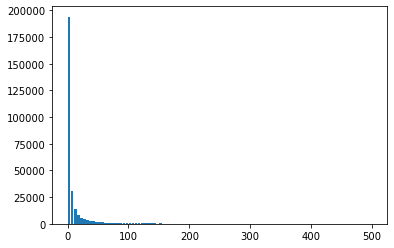

In [264]:
plt.hist(artist_gr['plays_count'],bins=100,rwidth=0.9,range=[0, 500])
#plt.ylim(ymin=0, ymax = 25000)

## Selección de Artitas y Usuarios

In [368]:
min_user_plays = 46
min_user_splays = 2402
filter_u = user_gr[user_gr['plays_count'] > min_user_plays]
filter_u = filter_u[filter_u['plays_sum'] > min_user_splays]


In [369]:
min_artist_plays = 8
min_artist_splays = 208
filter_p = artist_gr[artist_gr['plays_count'] > min_artist_plays]
filter_p = filter_p[filter_p['plays_sum'] > min_artist_splays]


In [370]:
filter_p = filter_p.reset_index()
filter_p[['artist']].head()

,artist
0,パール兄弟
1,phil hendrie
2,sara love
3,latex diamond
4,the pillbugs


In [371]:
filter_u = filter_u.reset_index()
filter_u[['user']].head()

,user
0,8d0384537845e7f2b1b8b3e8a9f67eb8d9439794
1,b88d16f3ebdad0bf701ecd46cf4725ea31911849
2,baee6143fb184f2014f05c737c28cd57d6d0486f
3,2a088c171293674c39d0e02f495c6f91362357b0
4,f27c8d76cf15dd6e79fec7affb684804475292de


In [372]:
data = pd.merge(data,filter_p[['artist']] ,how='inner',on='artist',validate = 'many_to_one')

In [373]:
data = pd.merge(data, filter_u[['user']], how='inner',on='user',validate = 'many_to_one')
data.tail()

,user,artist,plays
10679370,de509fbbeab3d5f78dbd2bee59a06ee3175e8d37,re-style,83
10679371,de509fbbeab3d5f78dbd2bee59a06ee3175e8d37,nexes,48
10679372,de509fbbeab3d5f78dbd2bee59a06ee3175e8d37,menace ii society,41
10679373,de509fbbeab3d5f78dbd2bee59a06ee3175e8d37,meagashira,79
10679374,de509fbbeab3d5f78dbd2bee59a06ee3175e8d37,dj mad dog & noize suppressor,52


In [374]:
len(data)

10679375

## Recomendación Preferencia por Popularidad

In [176]:
# Calificacion de peliculas basada en la ponderacion de su rating 
def rating_ponderado(x):
    """
    Input:
    x: datos de rating y votacion de las peliculas
    m: minimo numero de votos
    Output:
    rating ponderado
    """
    m = x['plays_max'].max()
    v = x['plays_count']
    R = x['plays_mean']
    return (v/(v+m) * R)


In [177]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

data_gr = data.groupby('artist').agg({'plays': ['count','sum', 'mean', 'min', 'max']})

# rename columns
data_gr.columns = ['plays_count', 'plays_sum', 'plays_mean', 'plays_min', 'plays_max']

# reset index to get grouped columns back
data_gr = data_gr.reset_index()


In [178]:
# si tiene al menos vmin votos, incluimos el artista
vmin = 1
musicRF = data_gr.copy().loc[data_gr['plays_count'] >= vmin]

musicRF['score'] = rating_ponderado(musicRF)

# ordenamos las peliculas de acuerdo con el score
musicRF = musicRF.sort_values('score', ascending=False)

# Mostramos el top15 de las peliculas
musicRF[['artist', 'plays_count', 'plays_sum', 'plays_mean', 'plays_max', 'score']].head(20)

,artist,plays_count,plays_sum,plays_mean,plays_max,score
252494,the beatles,53989,25267356.0,468.009335,51238.0,53.402874
217883,radiohead,54569,23068723.0,422.744104,106639.0,48.696341
212496,pink floyd,31293,13334516.0,426.118173,31957.0,29.602655
73856,coldplay,43102,13666539.0,317.074358,118857.0,29.564679
186241,metallica,30894,12856605.0,416.152165,39519.0,28.566996
194163,muse,32451,12525016.0,385.967027,46991.0,27.734265
199674,nine inch nails,21423,12169307.0,568.048686,71736.0,27.621106
220128,red hot chili peppers,33262,11148517.0,335.172780,30705.0,24.642018
140703,in flames,14948,9588188.0,641.436179,43226.0,22.087255
247942,system of a down,24748,9426895.0,380.915428,24862.0,21.236289


## Recomendación por filtrado colaborativo

In [41]:
# create a sparse matrix of all the users/plays

data['user_id'] = data['user'].cat.codes
data['artist_id'] = data['artist'].cat.codes
sparse_item_user = sparse.csr_matrix((data['plays'].astype(float), (data['artist_id'], data['user_id'])))
sparse_user_item = sparse.csr_matrix((data['plays'].astype(float), (data['user_id'], data['artist_id'])))

In [43]:
# Interacciones posibles
mat_dim = sparse_user_item.shape[0]*sparse_user_item.shape[1] 

# Numero de interacciones
plays = len(sparse_user_item.nonzero()[0]) 
sparsity = 100*(1 - (plays/mat_dim))
sparsity

99.98981982442358

In [217]:
def entrena(ratings, pct_val = 0.2):
    '''
    Input: Matriz de ratings
    Output: matriz de entrenamiento CE y de validacion CV, y user_inds
    
    Esta función toma la matriz orginal y enmascara un porcentaje de ratings pata la validacion
    El conjunto de validacion (CV) va a tener todos los ratings originales, mientras que el de entrenamiento (CE)
    reemplaza el porcentaje señalado con ceros
    
    pct_val: porcentaje de iteraciones a enmascarar
    user_inds: lista de usuarios aleatoriamente elegidos y enmascarados en CE.
    '''
    
    random.seed(0) # Semilla aeatoria
    
    CV = ratings.copy() 
    CV[CV != 0] = 1 # CV como una matriz binaria
    
    CE = ratings.copy() 
    non0_inds = CE.nonzero() # Indices donde hay interaccion
    non0_pares = list(zip(non0_inds[0], non0_inds[1])) # lista de indices usuario-item con interaccion
    
    num_muestra = int(np.ceil(pct_val*len(non0_pares))) 
    muestra = random.sample(non0_pares, num_muestra) # sub-muestreo sin reemplazo
    
    user_inds = [index[0] for index in muestra] # indices de usuario
    item_inds = [index[1] for index in muestra] # inidices de items
    
    CE[user_inds, item_inds] = 0 # Asigna 0 sobre las observaciones elegidas
    CE.eliminate_zeros() # Elimina los ceros en el arreglo sparce
    return CE, CV, list(set(user_inds)) 

In [218]:
CE, CV, users_V = entrena(prefs_sparse, pct_val = 0.2)

In [223]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((CE*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                          iterations = 50)

In [224]:
def auc_score(preds, prueba):
    '''
    Esta funcion obtiene el AUC. 
    Input:
    parameters:
    preds: las predicciones del sistema
    prueba: las ventas verdaderas
    Output:
    AUC
    '''
    
    fpr, tpr, umbrales = metrics.roc_curve(prueba, preds)
    return metrics.auc(fpr, tpr)   

In [225]:
def AUC_val(CE, users_V, preds, CV):
    '''
    Esta funcion calcula el AUC medio por usuario para todo usuario en el conjunto de validacion
    Input:
    CE: Conjunto de entrnamiento con un porcentaje de las interacciones originales enamscaradas
    preds: la matriz con las predicciones de los ratings para cada par usuario-item (lista
    con vectores de usuario y vectores de items)
    users_V: indices de los usuarios de validacion
    CV: conjunto de validacion 
    Output:
    AUC medio del CV para las interacciones usuario-item y para los items más populares
    '''
    
    # Inicializamos la lista para guardar el AUC de validacion 
    rec_auc = [] 
    # y el AUC para la recomendación por popularidad
    pop_auc = [] 
    
    # Tomamos la suma de interacciones por item para encontrar lo más popular
    pop_items = np.array(CV.sum(axis = 0)).reshape(-1) 
    item_vecs = preds[1]
    
    for user in users_V: 
        user_i = CE[user,:].toarray().reshape(-1) # usuario de validacion
        user_val = np.where(user_i == 0) # 
        
        # Toma la prediccion para el usuario-item
        user_vec = preds[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,user_val].reshape(-1)
        
        # Selecciona los ratings estimados para el usuario 
        actual = CV[user,:].toarray()[0,user_val].reshape(-1) 
        
        # Toma los pares con interacciones binarias de los datos originales
        pop = pop_items[user_val] # Popularidad del item
        rec_auc.append(auc_score(pred, actual)) # Calcula y guarda el AUC para el ususario
        pop_auc.append(auc_score(pop, actual)) # Calcula el AUC por popularidad

    
    return float('%.3f'%np.mean(rec_auc)), float('%.3f'%np.mean(pop_auc))  
   # Devuelve el AUC medio para validacion y por popularidad


In [226]:
AUC_val(CE, users_V, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], CV)

(0.956, 0.913)

In [88]:
#https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe

### Predicciones

In [195]:
# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 15
data_conf = (CE * alpha_val).astype('double')

#Fit the model
model.fit(data_conf)

In [212]:
data[data.artist == 'shakira'].head()

,user,artist,plays,user_id,artist_id
2459,0008af04f067b6a845cf110f19d8c6aebda01b21,shakira,118,50,233097
27346,00625a0f0b142474c26d019c8cbbd396d145a943,shakira,135,556,233097
112587,019ae68dde2d0215ad61a13a426bc23e182bd177,shakira,215,2296,233097
126163,01cbc6469c9cd5b9b1619ab65122c44e1eaa8a3c,shakira,538,2574,233097
130142,01dc9c94c7f5ebd4430d5b5380958d7298381980,shakira,58,2657,233097


In [205]:
#---------------------
# FIND SIMILAR ITEMS
#---------------------

# Find the 10 most similar
item_id = 73856
n_similar = 10

# Use implicit to get similar items.
similar = model.similar_items(item_id, n_similar)

In [204]:
# Print the names of our most similar artists
for item in similar:
    idx, score = item
    print(idx)
    print(data.artist.loc[data.artist_id == idx].iloc[0])

73856
coldplay
272564
u2
258212
the killers
194163
muse
202328
oasis
212967
placebo
252494
the beatles
80485
daft punk
220128
red hot chili peppers
88689
depeche mode


In [213]:
#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------

# Create recommendations for user with id 2025
user_id = 2574

# Use the implicit recommender.
recommended = model.recommend(user_id, sparse_user_item)

artists = []
scores = []

# Get artist names from ids
for item in recommended:
    idx, score = item
    artists.append(data.artist.loc[data.artist_id == idx].iloc[0])
    scores.append(score)

# Create a dataframe of artist names and scores
recommendations = pd.DataFrame({'artist': artists, 'score': scores})

print (recommendations)

           artist     score
0    mike doughty  1.415238
1   bran van 3000  1.387510
2     chumbawamba  1.386215
3  the submarines  1.357207
4   hilltop hoods  1.350226
5             poe  1.336546
6     save ferris  1.316762
7    gaelic storm  1.309828
8          wicked  1.278591
9             jem  1.278309


In [215]:
data[data.user_id == 2574].head(10)

,user,artist,plays,user_id,artist_id
126159,01cbc6469c9cd5b9b1619ab65122c44e1eaa8a3c,mika,759,2574,188205
126160,01cbc6469c9cd5b9b1619ab65122c44e1eaa8a3c,christina aguilera,670,2574,70027
126161,01cbc6469c9cd5b9b1619ab65122c44e1eaa8a3c,gogol bordello,630,2574,126542
126162,01cbc6469c9cd5b9b1619ab65122c44e1eaa8a3c,m.i.a.,612,2574,176588
126163,01cbc6469c9cd5b9b1619ab65122c44e1eaa8a3c,shakira,538,2574,233097
126164,01cbc6469c9cd5b9b1619ab65122c44e1eaa8a3c,the beatles,523,2574,252494
126165,01cbc6469c9cd5b9b1619ab65122c44e1eaa8a3c,outkast,470,2574,205889
126166,01cbc6469c9cd5b9b1619ab65122c44e1eaa8a3c,amy winehouse,446,2574,22576
126167,01cbc6469c9cd5b9b1619ab65122c44e1eaa8a3c,lily allen,423,2574,170866
126168,01cbc6469c9cd5b9b1619ab65122c44e1eaa8a3c,gabriel iglesias,390,2574,121622


### HIBRIDO CON LIGHT FM

Realizamos la implementación de un modelo hibrído que incorpora las características socio-demográficas en el modelo mediante el uso de la librería LigthFM.

In [381]:
dataP.head()

,user,gender,age,country
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States


In [382]:
dataP = dataP.dropna()

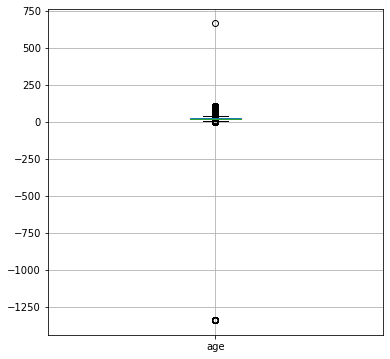

In [383]:
dataP.boxplot(column = 'age', patch_artist = True, return_type='axes', figsize= [6,6] )

Dado que la edad contiene muchos valores atípicos, se decide excluirlos de la base.

In [384]:
dataP = dataP[dataP['age'].between(10, 90, inclusive = True)]

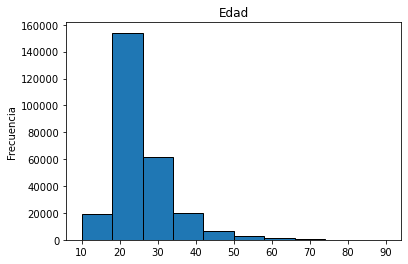

In [385]:
plt.hist(dataP['age'], bins=10, edgecolor='black')

plt.title('Edad')

plt.ylabel("Frecuencia")

plt.show()

Se opta por un rango para la definición de la edad.

In [386]:
#Crear un Rango de edad

bins = [10, 20, 30, 45, 60, 90]

names = ["1", "2", "3", "4", "5"]

dataP['r_edad'] = pd.cut(dataP['age'], bins, labels = names)

In [387]:
del dataP['age']

In [388]:
dataP.head()

,user,gender,country,r_edad
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,Germany,2
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,Mexico,1
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,United States,2
5,0000c176103e538d5c9828e695fed4f7ae42dd01,m,United Kingdom,1
6,0000ee7dd906373efa37f4e1185bfe1e3f8695ae,m,Finland,1


Transformamos las variables a dummys para poder usarlas matricialmente en el modelo.

In [389]:
dummy = pd.get_dummies(dataP[['r_edad','gender','country']])
dummy.head()

,r_edad_1,r_edad_2,r_edad_3,r_edad_4,r_edad_5,gender_f,gender_m,country_Afghanistan,country_Albania,country_Algeria,...,country_Vanuatu,country_Venezuela,country_Viet Nam,"country_Virgin Islands, British","country_Virgin Islands, U.s.",country_Wallis and Futuna,country_Western Sahara,country_Yemen,country_Zambia,country_Zimbabwe
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [390]:
data_dummy = pd.concat([dataP[['user']], dummy], axis=1) 
data_dummy.head()

,user,r_edad_1,r_edad_2,r_edad_3,r_edad_4,r_edad_5,gender_f,gender_m,country_Afghanistan,country_Albania,...,country_Vanuatu,country_Venezuela,country_Viet Nam,"country_Virgin Islands, British","country_Virgin Islands, U.s.",country_Wallis and Futuna,country_Western Sahara,country_Yemen,country_Zambia,country_Zimbabwe
0,00000c289a1829a808ac09c00daf10bc3c4e223b,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0000c176103e538d5c9828e695fed4f7ae42dd01,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0000ee7dd906373efa37f4e1185bfe1e3f8695ae,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [391]:
data_dummy.shape

(265442, 246)

In [392]:
#identificando duplicados
data_dummy[data_dummy.duplicated(subset=['user'], keep=False)]

,user,r_edad_1,r_edad_2,r_edad_3,r_edad_4,r_edad_5,gender_f,gender_m,country_Afghanistan,country_Albania,...,country_Vanuatu,country_Venezuela,country_Viet Nam,"country_Virgin Islands, British","country_Virgin Islands, U.s.",country_Wallis and Futuna,country_Western Sahara,country_Yemen,country_Zambia,country_Zimbabwe


In [194]:
filter_dummy = data_dummy['user']
filter_dummy = filter_dummy[filter_dummy].index.tolist()
len(filter_dummy)

265442

In [393]:
data = data[data.user.isin(filter_dummy)]

print('Los nuevo datos tienen tamaño:\t{}'.format(data.shape))

Los nuevo datos tienen tamaño:	(8180361, 3)


In [394]:
data.tail()

,user,artist,plays
10679370,de509fbbeab3d5f78dbd2bee59a06ee3175e8d37,re-style,83
10679371,de509fbbeab3d5f78dbd2bee59a06ee3175e8d37,nexes,48
10679372,de509fbbeab3d5f78dbd2bee59a06ee3175e8d37,menace ii society,41
10679373,de509fbbeab3d5f78dbd2bee59a06ee3175e8d37,meagashira,79
10679374,de509fbbeab3d5f78dbd2bee59a06ee3175e8d37,dj mad dog & noize suppressor,52


In [395]:
dataC = pd.merge(data,data_dummy[['user']] ,how='inner',on='user',validate = 'many_to_one')

In [396]:
dataC.shape

(8180361, 3)

In [397]:
user_gr = dataC.groupby('user').agg({'plays': ['count','sum', 'mean', 'min', 'max']})
user_gr.columns = ['plays_count', 'plays_sum', 'plays_mean', 'plays_min', 'plays_max']
user_gr = user_gr.sort_values('plays_count', ascending=False)
user_gr.shape

(159322, 5)

In [398]:
user_gr = user_gr.reset_index()

In [399]:
data_dummy = pd.merge(data_dummy,user_gr[['user']] ,how='inner',on='user',validate = 'one_to_one')

In [400]:
data_dummy.shape

(159322, 246)

In [401]:
artist_gr = dataC.groupby('artist').agg({'plays': ['count','sum', 'mean', 'min', 'max']})
artist_gr.columns = ['plays_count', 'plays_sum', 'plays_mean', 'plays_min', 'plays_max']
artist_gr = artist_gr.sort_values('plays_count', ascending=False)
artist_gr.shape

(70475, 5)

In [402]:
#use implicit to get recommended for users
from lightfm.cross_validation import random_train_test_split

In [403]:
user_feat = data_dummy[data_dummy.columns[1:]]
user_features = scipy.sparse.csr_matrix(user_feat.values)

In [404]:
# create a sparse matrix of all the users/plays
# map each artist and user to a unique numeric value
dataC['user'] = dataC['user'].astype("category")
dataC['artist'] = dataC['artist'].astype("category")
dataC['user_id'] = dataC['user'].cat.codes
dataC['artist_id'] = dataC['artist'].cat.codes
sparse_item_user = sparse.csr_matrix((dataC['plays'].astype(float), (dataC['artist_id'], dataC['user_id'])))
sparse_user_item = sparse.csr_matrix((dataC['plays'].astype(float), (dataC['user_id'], dataC['artist_id'])))

In [405]:
sparse_user_item

<159322x70475 sparse matrix of type '<class 'numpy.float64'>'
	with 8180361 stored elements in Compressed Sparse Row format>

In [406]:
from lightfm import LightFM
#create FM model with tuned parameters
model_fm = LightFM(learning_rate=0.05, no_components = 50, loss='warp')

In [407]:
#split train test
train,test = random_train_test_split(sparse_user_item)#20% test

In [408]:
#train model
model_fm.fit(train, epochs = 25, user_features = user_features)

In [409]:
from lightfm.evaluation import auc_score

train_auc = auc_score(model_fm, train, user_features=user_features).mean()
test_auc = auc_score(model_fm, test, user_features=user_features).mean()



In [410]:
print(train_auc,test_auc)

0.97285295 0.9571638
